In [1]:
# pip install pydicom
# pip install xlrd
# pip install maskRCNN

import pandas as pd 
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
#from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm
import seaborn as sns
import pydicom as dcm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import cv2
#from google.colab import drive
%matplotlib inline 
IS_LOCAL = False
import os
from datetime import datetime
random_stat = 123
np.random.seed(random_stat)

In [2]:
## all functions defined here

def convert_img_size(arch, path_to_images):
    image_names = os.listdir(path_to_images)
    arch=arch.upper()
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print("Start : date and time =", dt_string)	
    if (arch=='YOLO'):
        print('Initiated YOLO images resize to (416,416) @',dt_string,' HRS')
        for n, image in enumerate(image_names):
            img_yolo = cv2.imread(os.path.join(path_to_images,image))
            img_yolo = cv2.resize(img_yolo, (416,416))
            #early exit to test
            if (n ==10):
               break
            #X.append(img_yolo)
    elif (arch=='SSD'):
        print('Initiated SSD images resize to (416,416) @',dt_string)
        for n, image in enumerate(image_names):
            img_ssd = cv2.imread(os.path.join(path_to_images,image))
            img_ssd = cv2.resize(img_ssd,(300,300))
    elif (arch=='VGGNET'):
        print('Initiated VGGNET images resize to (416,416) @',dt_string)
        for n, image in enumerate(image_names):
            img_vggnet = cv2.imread(os.path.join(path_to_images,image))
            img_vggnet = cv2.resize(img_vggnet, (256,256))
    else:
        print(' Architecture entered : ',arch,' is NOT valid. Valid options are YOLO / SSD / VGGNET')
        return 
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print('Completed ',arch,' resize @',dt_string,' HRS')          

    

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        #imagePath = os.path.join(img_path,"stage_2_train_images/",patientImage)
        imagePath = os.path.join("stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()
    
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(data_path)
    for i, img_name in tqdm(enumerate(image_names)):
        #imagePath = os.path.join(img_path,data_path,img_name)
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns
        data_df.loc[idx,'Path'] = imagePath
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 

def test_img_resize(imagePath):
    read_org_img = dcm.dcmread(os.path.join(imagePath))
    read_org_img_data=dcm.read_file(os.path.join(imagePath))
    org_array = read_org_img_data.pixel_array # get image array
    org_width = read_org_img_data.Rows
    org_height = read_org_img_data.Columns
    plt.imshow(read_org_img.pixel_array, cmap=plt.cm.bone) 
    plt.title('ID: {}\n Height: {} Width: {} \nType: {} '.format(imagePath,org_height, org_width, 'Original'))
    plt.show()
    outdir = 'C:\\Temp||'

    # CV2 does not support DCM format hence convert image to JPG format
    imagePath = imagePath.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(imagePath),org_array)
    ## Resize image for YOLO
    img_yolo = cv2.imread(os.path.join(imagePath))
    img_yolo = cv2.resize(img_yolo, (416,416))
    plt.imshow(img_yolo, cmap=plt.cm.bone) 
    plt.title('ID: {}\n Height: {} Width: {} \nType: {} '.format(imagePath,416, 416, 'YOLO'))
    plt.show()

    ## Resize image for SSD
    img_SSD = cv2.imread(os.path.join(imagePath))
    img_SSD = cv2.resize(img_SSD, (300,300))
    plt.imshow(img_SSD, cmap=plt.cm.bone) 
    plt.title('ID: {}\n Height: {} Width: {} \nType: {} '.format(imagePath,300, 300, 'SSD'))
    plt.show()
    
    ## Resize image for VGGNET
    img_vggNet = cv2.imread(os.path.join(imagePath))
    img_vggNet = cv2.resize(img_SSD, (256,256))
    plt.imshow(img_vggNet, cmap=plt.cm.bone) 
    plt.title('ID: {}\n Height: {} Width: {} \nType: {} '.format(imagePath,256, 256, 'VGGNet'))
    plt.show()    
    
    
    #Titles =["Original", "YOLO", "SSD", "VGGNet"] 
    #images =[read_org_img.pixel_array, img_yolo, img_SSD, img_vggNet] 
    #count = 4
    #for i in range(count):
     #   plt.subplot(2, 2, i + 1) 
     #   plt.title(Titles[i]) 
     #   plt.imshow(images[i]) 
        
    #plt.show()         
        
        

In [3]:
#drive.mount('/content/my-drive')
#!ls '/content/my-drive/My Drive'
#class_info_df = pd.read_csv('/content/my-drive/My Drive/stage_2_detailed_class_info.csv')
#train_labels_df = pd.read_csv('/content/my-drive/My Drive/stage_2_train_labels.csv')      

class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv') 
test_class_df  = pd.read_csv('stage_2_sample_submission.csv') 
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")
class_info_df.sample(10)

missing_data(train_labels_df)
missing_data(class_info_df)

Detailed class info -  rows: 26684, columns: 2
Train labels -  rows: 30227, columns: 6


patientId                         class
2929   319381e2-67f9-4fb1-85fc-a8999515f25b  No Lung Opacity / Not Normal
5460   4736f2b8-2834-467c-a8a4-49fbd25a18af                  Lung Opacity
18599  b9a77d83-e154-47a8-8191-bb6ae5842eae  No Lung Opacity / Not Normal
13197  8aa2f1cd-a9f5-4f10-8dd7-1d40b2fbaf50                  Lung Opacity
19650  c3803501-05e4-4141-a61b-7af3187ade89                  Lung Opacity
21120  cfeb791e-5a3d-41ee-a55c-c3886955d027  No Lung Opacity / Not Normal
6608   512d246f-2480-4820-810a-dfa2d188f9b6                        Normal
4276   3ce7cd1e-20d7-4892-b0a3-1092f5d27f09  No Lung Opacity / Not Normal
6212   4dead6d7-4f3a-4ac4-9ca6-772104bd4d23                        Normal
22201  d995aeb6-09ae-4fd0-a8ad-cdb78205300a                        Normal

height         width             y             x  Target  \
Total    20672.000000  20672.000000  20672.000000  20672.000000     0.0   
Percent     68.389188     68.389188     68.389188     68.389188     0.0   

         patientId  
Total          0.0  
Percent        0.0

class  patientId
Total      0.0        0.0
Percent    0.0        0.0

Text(0.0, 11824, '44.30%')

Text(1.0, 8854, '33.17%')

Text(2.0, 6015, '22.53%')

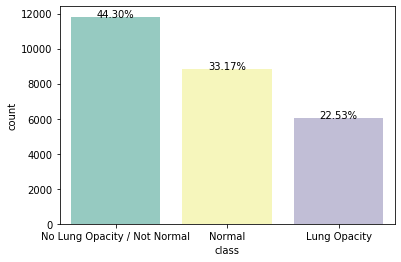

In [4]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

Detailed class info (after merge) -  rows: 30227, columns: 7
train_class_df(patientID,x,y,width,height) is UNIQUE : True


patientId   x   y  width  height  Target  \
3121   364ed67e-971c-4c7e-9713-aeb0eb0bc6d3 NaN NaN    NaN     NaN       0   
14432  8ebe4294-7b95-403d-985b-da0943b80f3f NaN NaN    NaN     NaN       0   
27930  f7a9a992-549e-47d4-8ffb-ba22fef38d8d NaN NaN    NaN     NaN       0   
26679  ed8b97b1-98f6-4ccb-b665-5b7027b302b3 NaN NaN    NaN     NaN       0   
29713  23011568-4563-4a06-96fe-9c29f08ff01c NaN NaN    NaN     NaN       0   

                              class  
3121                         Normal  
14432                        Normal  
27930  No Lung Opacity / Not Normal  
26679                        Normal  
29713  No Lung Opacity / Not Normal

Text(0.5, 1.0, 'Chest exams class and Target')

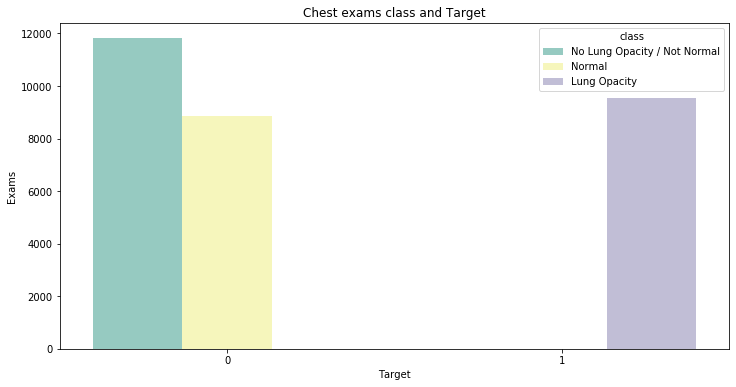

In [5]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

print(f"Detailed class info (after merge) -  rows: {train_class_df.shape[0]}, columns: {train_class_df.shape[1]}")
#train_class_df.to_excel(r'C:\\temp\\train_class_df_merge.xlsx', index = False, header=True)
print('train_class_df(patientID,x,y,width,height) is UNIQUE :',train_class_df.set_index(['patientId', 'x', 'y', 'width', 'height']).index.is_unique)
train_class_df.sample(5)
# All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.
# The chest examinations with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal.
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

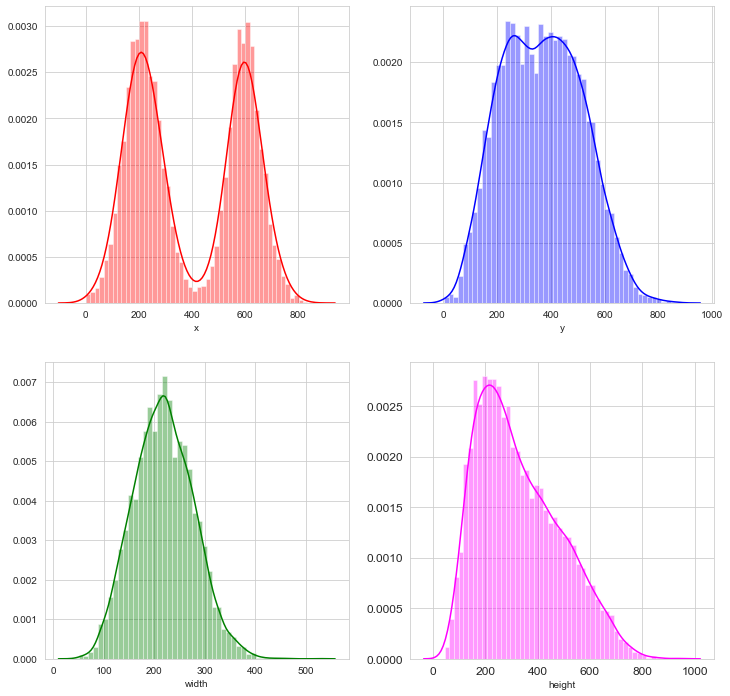

In [6]:
## Explore DICOM data
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


In [7]:
process_dicom_data(train_class_df,'stage_2_train_images/')
process_dicom_data(test_class_df,'stage_2_test_images/')
test_class_df = test_class_df.drop('PredictionString',1)

print(train_class_df.columns)
train_class_df.head()

test_class_df.head()


Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'Modality',
       'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition',
       'ConversionType', 'Rows', 'Columns', 'PixelSpacing', 'Path'],
      dtype='object')


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality PatientAge PatientSex  \
0  No Lung Opacity / Not Normal       CR         51          F   
1  No Lung Opacity / Not Normal       CR         48          F   
2  No Lung Opacity / Not Normal       CR         19          M   
3                        Normal       CR         28          M   
4                  Lung Opacity       CR         32          F   

  BodyPartExamined ViewPosition ConversionType  Rows Columns PixelSpacing  \
0            CHEST           PA            WSD  1024    1024        0.143   
1            CHEST           PA            WSD  1024    1024        0.194   
2            CHEST           AP            WSD  1024    1024        0.168   
3            CHEST           PA            WSD  1024    1024        0.143   
4            CHEST           AP            WSD  1024    1024        0.139   

                                                Path  
0  stage_2_train_images/0004cfab-14fd-4e49-80ba-6...  
1  stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...  
2  stage_2_train_images/00322d4d-1c29-4943-afc9-b...  
3  stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...  
4  stage_2_train_images/00436515-870c-4b36-a041-d...

patientId Modality PatientAge PatientSex  \
0  0000a175-0e68-4ca4-b1af-167204a7e0bc       CR         46          F   
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813       CR         22          F   
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6       CR         64          M   
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d       CR         75          F   
4  00100a24-854d-423d-a092-edcf6179e061       CR         66          F   

  BodyPartExamined ViewPosition ConversionType  Rows Columns PixelSpacing  \
0            CHEST           PA            WSD  1024    1024        0.194   
1            CHEST           PA            WSD  1024    1024        0.143   
2            CHEST           PA            WSD  1024    1024        0.143   
3            CHEST           PA            WSD  1024    1024        0.143   
4            CHEST           AP            WSD  1024    1024        0.139   

                                                Path  
0  stage_2_test_images/0000a175-0e68-4ca4-b1af-16...  
1  stage_2_test_images/0005d3cc-3c3f-40b9-93c3-46...  
2  stage_2_test_images/000686d7-f4fc-448d-97a0-44...  
3  stage_2_test_images/000e3a7d-c0ca-4349-bb26-5a...  
4  stage_2_test_images/00100a24-854d-423d-a092-ed...

## Body Part Examined

In [8]:
print("Body Part Examined: train:",train_class_df['BodyPartExamined'].unique(), 
      "test:", test_class_df['BodyPartExamined'].unique())

Body Part Examined: train: ['CHEST'] test: ['CHEST']


## Patient Age

In [9]:
tmp = train_class_df.groupby(['Target', 'PatientAge'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'PatientAge']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

In [10]:
tmp = train_class_df.groupby(['class', 'PatientAge'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientAge']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

Text(0.5, 1.0, 'Train set: Chest exams Age and Target')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 97 Text xticklabel objects>)

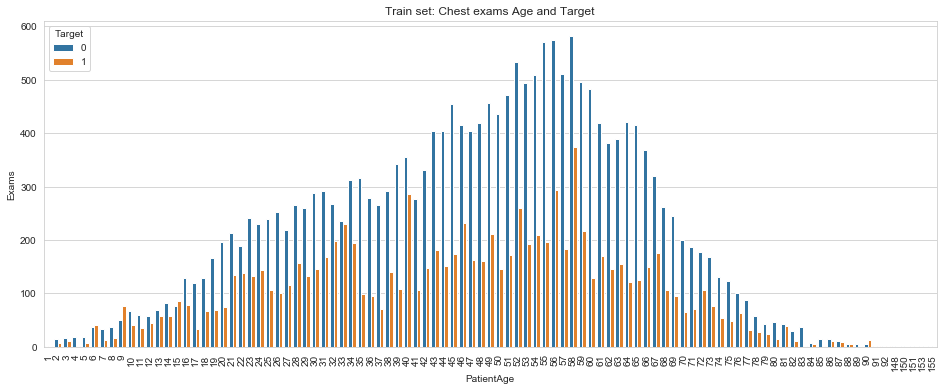

In [11]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='Target',data=df2)
plt.title("Train set: Chest exams Age and Target")
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Train set: Chest exams Age and class')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 97 Text xticklabel objects>)

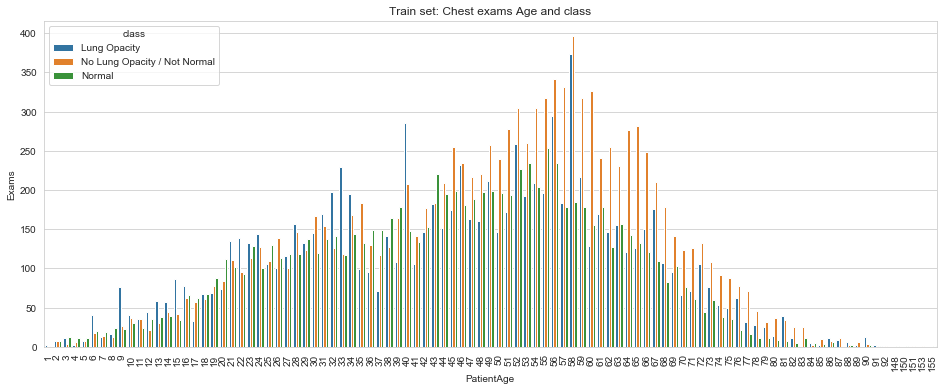

In [12]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='class',data=df3)
plt.title("Train set: Chest exams Age and class")
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000')

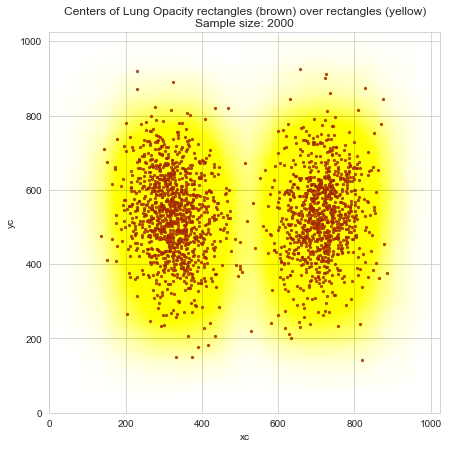

In [13]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

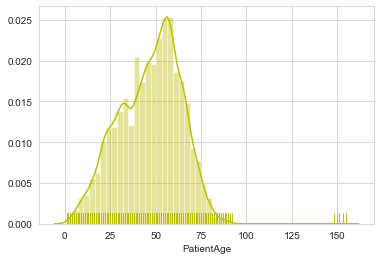

In [14]:
sns.distplot(train_class_df['PatientAge'],color="y",rug=True)
plt.show()

In [15]:
train_class_df.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'Modality',
       'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition',
       'ConversionType', 'Rows', 'Columns', 'PixelSpacing', 'Path'],
      dtype='object')

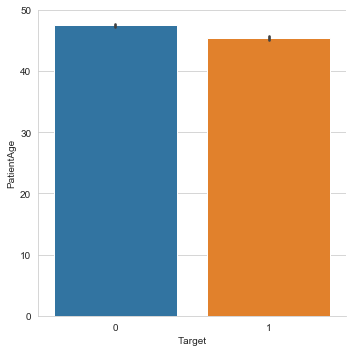

In [16]:
sns.catplot(x='Target',y='PatientAge',data=train_class_df,kind='bar')

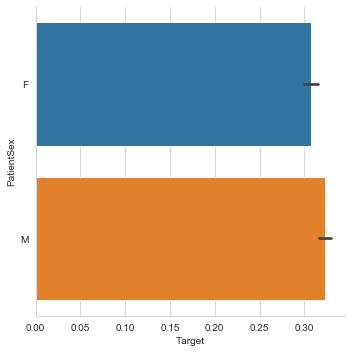

In [17]:
sns.catplot(x='Target',y='PatientSex',data=train_class_df,kind='bar')

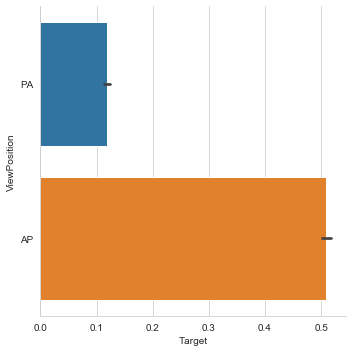

In [18]:
sns.catplot(x='Target',y='ViewPosition',data=train_class_df,kind='bar')

In [19]:
#image_train_path = os.listdir(img_path+'/stage_2_train_images')
#image_test_path = os.listdir(img_path+'/stage_2_test_images')

image_train_path = os.listdir('stage_2_train_images')
image_test_path = os.listdir('stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())      


Number of images in train set: 26684 
Number of images in test set: 3000
Unique patientId in  train_class_df:  26684


In [20]:
## DICOM METADATA

samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join("stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [21]:
train_class_df['patientId'][train_class_df['Target']==1].sample(1)

29822    26ae031c-b211-45f4-ac4d-b2983db93aa6
Name: patientId, dtype: object

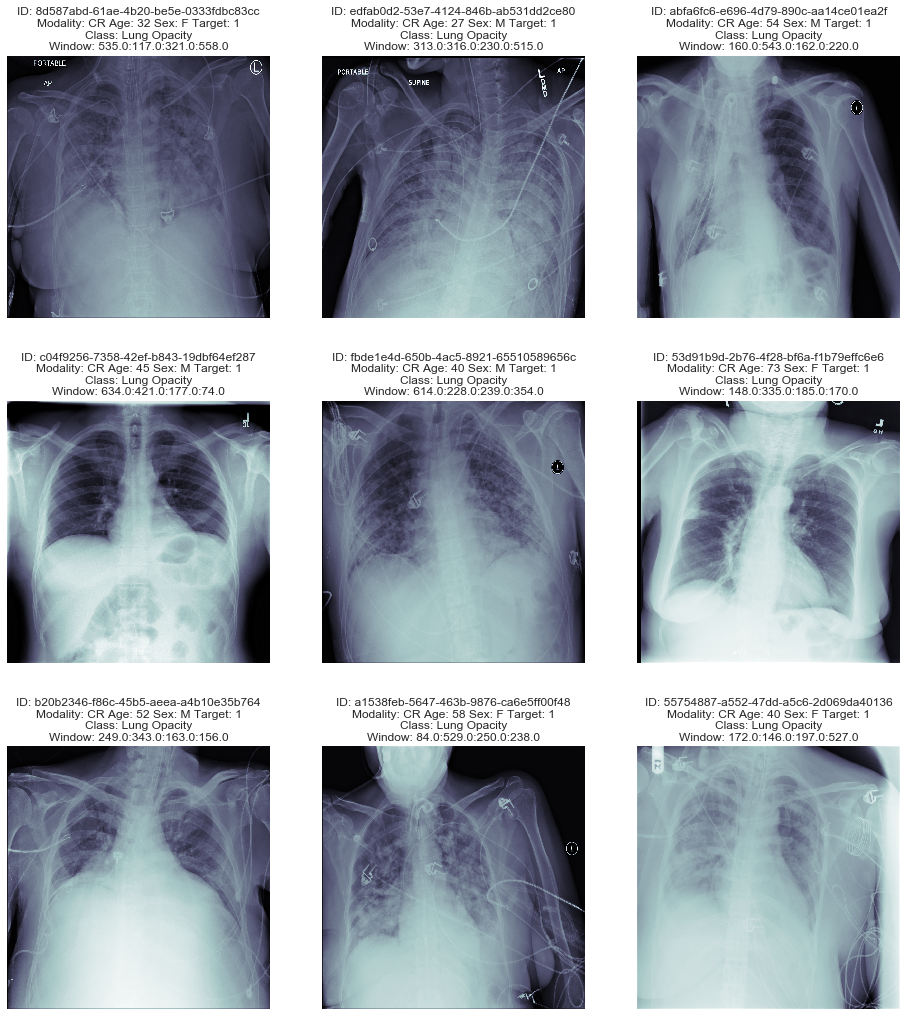

In [22]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

In [23]:
train_class_df.columns
test_class_df.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'Modality',
       'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition',
       'ConversionType', 'Rows', 'Columns', 'PixelSpacing', 'Path'],
      dtype='object')

Index(['patientId', 'Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined',
       'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing',
       'Path'],
      dtype='object')

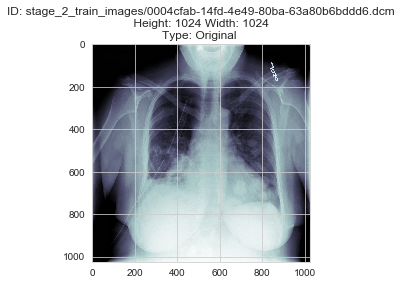

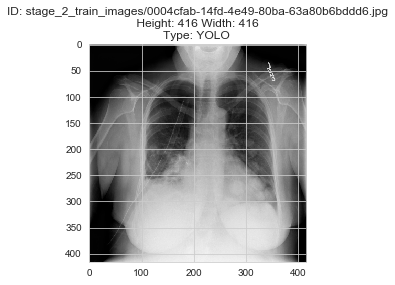

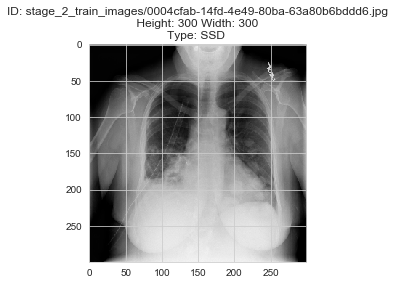

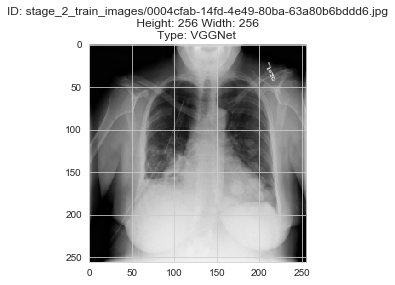

In [24]:
## RESIZE at glance
test_img_resize('stage_2_train_images/'+list(train_class_df[:1].T.to_dict().values())[0]['patientId']+'.dcm')       


In [25]:
final_train_class_df= pd.DataFrame(train_class_df, 
                                   columns = ['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'Modality',
                                              'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition',
                                              'ConversionType', 'Rows', 'Columns', 'PixelSpacing','Path'])

final_train_class_df.to_excel(r'C:\\temp\\final_train_class_df.xlsx', index = False, header=True)

final_test_class_df= pd.DataFrame(test_class_df, 
                                   columns = ['patientId','Path'])

final_test_class_df.to_excel(r'C:\\temp\\final_test_class_df.xlsx', index = False, header=True)


In [27]:
final_train_class_df = pd.read_excel('C:\\temp\\final_train_class_df.xlsx')
final_train_class_df.shape
final_train_class_df.set_index(['patientId', 'x', 'y', 'width', 'height']).index.is_unique
## remove duplicate data from final_train_class_df
final_unq_train_class_df=final_train_class_df.drop_duplicates()
final_unq_train_class_df.to_excel(r'C:\\temp\\final_train_unq_class_df.xlsx', index = False, header=True)
final_unq_train_class_df.shape
final_unq_train_class_df.head()

(30227, 17)

True

(30227, 17)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality  PatientAge PatientSex  \
0  No Lung Opacity / Not Normal       CR          51          F   
1  No Lung Opacity / Not Normal       CR          48          F   
2  No Lung Opacity / Not Normal       CR          19          M   
3                        Normal       CR          28          M   
4                  Lung Opacity       CR          32          F   

  BodyPartExamined ViewPosition ConversionType  Rows  Columns  PixelSpacing  \
0            CHEST           PA            WSD  1024     1024         0.143   
1            CHEST           PA            WSD  1024     1024         0.194   
2            CHEST           AP            WSD  1024     1024         0.168   
3            CHEST           PA            WSD  1024     1024         0.143   
4            CHEST           AP            WSD  1024     1024         0.139   

                                                Path  
0  stage_2_train_images/0004cfab-14fd-4e49-80ba-6...  
1  stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...  
2  stage_2_train_images/00322d4d-1c29-4943-afc9-b...  
3  stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...  
4  stage_2_train_images/00436515-870c-4b36-a041-d...

## TRAIN & TEST images conversion from DCM to JPG

In [29]:

# Specify the .dcm folder path
folder_path = "stage_2_train_images"
# Specify the output jpg/png folder path
jpg_folder_path = "JPG_train"
images_path = os.listdir(folder_path)
#print(images_path)
for n, image in enumerate(images_path):
    ds = dcm.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

In [ ]:
# Specify the .dcm folder path
folder_path = "stage_2_test_images"
# Specify the output jpg/png folder path
jpg_folder_path = "JPG_test"
images_path = os.listdir(folder_path)
#print(images_path)
for n, image in enumerate(images_path):
    ds = dcm.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.jpg')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)


## RESIZE TRAIN & TEST sets    

In [30]:
#convert_img_size(arch,image_folder)
#convert_img_size('YOLO','JPG_train')
#convert_img_size('SSD','JPG_train')
#convert_img_size('VGGNET','JPG_train')

convert_img_size('YOLO','JPG_train')

Start : date and time = 23/07/2020 13:59:03
Initiated YOLO images resize to (416,416) @ 23/07/2020 13:59:03  HRS
Completed  YOLO  resize @ 23/07/2020 13:59:05  HRS


## YOLO